# Apprentissage statistique : Implémentation d'un réseau de neurones

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Afin d'implémenter un réseau de neurones, on se dote de modules qui constituent des couches de notre réseau.

## Module linéaire

In [54]:
class LinearModule(object):
    """
    Classe permettant d'implémenter un module linéaire effectuant un produit scalaire theta*x
    """
    def __init__(self, input_dim, output_dim, eps = 0.001):
        #self.input_dim = input_dim
        #self.output_dim = output_dim
        self.eps = eps
        self.theta = np.random.uniform(-1.0, 1.0, (input_dim, output_dim))
        self.gradient = np.zeros((input_dim, output_dim))
    
    def forward(self, x):
        """
        Retourne le produit scalaire theta * x
        """
        return np.dot(x, self.theta)
    
    def backward(self, x, delta):
        """
        Calcul du gradient en fonction des paramètres puis ajout au gradient du module.
        Retourne le gradient en fonction de l'entrée x
        """
        self.gradient += np.dot(delta, x).T
        #print("Gradient")
        #print(self.gradient)
        return self.theta.dot(delta)   
    
    def zero_gradient(self):
        """
        Remise à zéro du gradient stocké en mémoire
        """
        self.gradient.fill(0)
        
    def update_params(self):
        """
        Mise à jour des paramètres theta
        """
        self.theta -= self.eps * self.gradient
        
        #print("Theta")
        #print(self.theta)

## Fonction de coût

In [48]:
class MSE(object):
    
    def forward(self, ypred, y):
        return np.mean(0.5 * (ypred - y.reshape(ypred.shape))**2)
    
    def backward(self, ypred, y):
        return np.mean((ypred - y.reshape(ypred.shape)))

## Fonction d'activation

In [86]:
class Tanh(object):
    
    def forward(self, x):
        return np.tanh(x)
    
    def backward(self, x, delta):
        self.grad = np.dot(delta,(1.0 - np.tanh(x)**2)).T
        return self.grad
        
    def updateParams(self, delta):
        return

    def zero_gradient(self):
        return

## Container

Afin de faciliter l'utilisation de réseaux de neurones, on se dote d'un container Net permettant de faciliter la manipulation d'ensemble de modules.

In [15]:
class Net(object):
    
    def __init__(self, layers =[]):
        self.layers = layers
    
    def addLayer(self, layer):
        self.layers.add(layer)
        
    def forward(self, x):
        pred = x
        for i in self.layers:
            pred = i.forward(pred)
        return pred
    
    def backward(self, x, grad_loss):
        raise NotImplementedError()
            
        
    def zero_gradient(self):
        [layer.zero_gradient() for layer in self.layers]
    
    def predict(self, x):
        return np.sign(self.forward(x))
    
    def score(self, x, y):
        return (self.predict(x).reshape(-1) == y).mean()

## Test d'un modèle linéaire sur les données breast cancer

### Import des données

In [6]:
def read_libsvm(fname):
    with open(fname) as f:
        x,y  =list(),list()
        for l in f:
            line = l.strip().split(" ")
            y.append(int(line[0]))
            x.append([float(s.split(":")[1]) for s in line[1:]])
    return np.array(x),np.array(y)

datax, datay = read_libsvm("breast")
datay[datay == 2] = -1
datay[datay == 4] = 1

On teste le bon fonctionnement de notre couche linéaire en utilisant un réseau à deux couches linéaires successives. L'apprentissage est fait en mini-batch.

In [60]:
t = Tanh()
pred = t.forward(linear1.forward(datax))
t.backward(x, delta)

array([[ 0.01158028,  0.01238525,  0.00903602,  0.00903602,  0.00903602,
         0.01238525,  0.00903602,  0.00903602,  0.00903602,  0.00903602],
       [ 0.0220713 ,  0.02360554,  0.01722209,  0.01722209,  0.01722209,
         0.02360554,  0.01722209,  0.01722209,  0.01722209,  0.01722209],
       [-0.00238573, -0.00255157, -0.00186157, -0.00186157, -0.00186157,
        -0.00255157, -0.00186157, -0.00186157, -0.00186157, -0.00186157]])

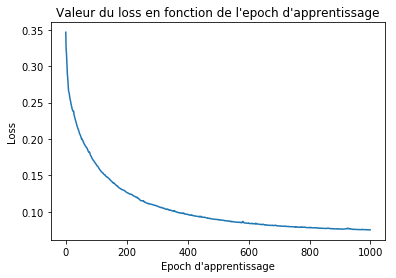

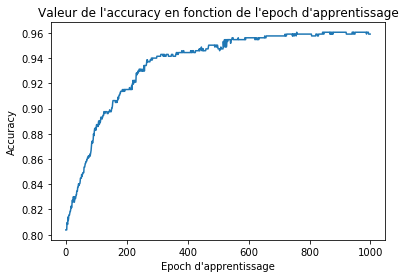

In [58]:
"""
Modèle utilisé : x (,10) -> Linear (10, 3) -> Linear (3, 1) -> prediction
"""

loss_histo = []
acc_histo = []
indices = list(range(len(datax)))
linear1 = LinearModule(10,3)
linear2 = LinearModule(3,1)
net = Net([linear1, linear2])
mse = MSE()
for k in range(1000):
    net.zero_gradient()
    for j in range(32):
        #Shuffle
        np.random.shuffle(indices)
        i = indices[0]
        x = datax[i].reshape((1, -1))
        y = datay[i]
        #Predictions, phase forward
        pred = linear1.forward(x)
        predFinale = linear2.forward(pred)
        #Calcul du cout 
        loss = mse.forward(predFinale, y)
        #Calcul des gradients
        grad_loss = mse.backward(predFinale, y)
        delta = linear2.backward(pred, grad_loss)
        linear1.backward(x, delta)
    linear2.update_params()
    linear1.update_params()
    fullpred = net.forward(datax)
    loss_histo.append(mse.forward(net.forward(datax), datay))
    acc_histo.append((np.sign(fullpred) == datay.reshape(fullpred.shape)).mean())

plt.plot(loss_histo)
plt.xlabel("Epoch d'apprentissage")
plt.ylabel("Loss")
plt.title("Valeur du loss en fonction de l'epoch d'apprentissage")

plt.figure()
plt.plot(acc_histo)
plt.xlabel("Epoch d'apprentissage")
plt.ylabel("Accuracy")
plt.title("Valeur de l'accuracy en fonction de l'epoch d'apprentissage")

## Réseau non linéaire

En faisant suivre une couche linéaire par une fonction d'activation (comme la tangente hyperbolique) on obtient des classifications non linéaires.

### Données jouet

Pour pouvoir visualiser la non linéarité de la classification de notre réseau, on se dote de données jouet de type XOR. Les fonctions ci-dessous proviennent de l'UE ARF et permettent de générer et visualiser ce genre de données.

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

def plot_data(data,labels=None):
    """
    Affiche des donnees 2D
    :param data: matrice des donnees 2d
    :param labels: vecteur des labels (discrets)
    :return:
    """
    cols,marks = ["red", "blue","green", "orange", "black", "cyan"],[".","+","*","o","x","^"]
    if labels is None:
        plt.scatter(data[:,0],data[:,1],marker="x")
        return
    for i,l in enumerate(sorted(list(set(labels.flatten())))):
        plt.scatter(data[labels==l,0],data[labels==l,1],c=cols[i],marker=marks[i])

def plot_frontiere(data,f,step=20):
    """ Trace un graphe de la frontiere de decision de f
    :param data: donnees
    :param f: fonction de decision
    :param step: pas de la grille
    :return:
    """
    grid,x,y=make_grid(data=data,step=step)
    plt.contourf(x,y,f(grid).reshape(x.shape),colors=('gray','red'),levels=[-1,0,1])

def make_grid(data=None,xmin=-5,xmax=5,ymin=-5,ymax=5,step=20):
    """ Cree une grille sous forme de matrice 2d de la liste des points
    :param data: pour calcluler les bornes du graphe
    :param xmin: si pas data, alors bornes du graphe
    :param xmax:
    :param ymin:
    :param ymax:
    :param step: pas de la grille
    :return: une matrice 2d contenant les points de la grille
    """
    if data is not None:
        xmax, xmin, ymax, ymin = np.max(data[:,0]),  np.min(data[:,0]), np.max(data[:,1]), np.min(data[:,1])
    x, y =np.meshgrid(np.arange(xmin,xmax,(xmax-xmin)*1./step), np.arange(ymin,ymax,(ymax-ymin)*1./step))
    grid=np.c_[x.ravel(),y.ravel()]
    return grid, x, y


def gen_arti(centerx=1,centery=1,sigma=0.1,nbex=1000,data_type=0,epsilon=0.02):
    """ Generateur de donnees,
        :param centerx: centre des gaussiennes
        :param centery:
        :param sigma: des gaussiennes
        :param nbex: nombre d'exemples
        :param data_type: 0: melange 2 gaussiennes, 1: melange 4 gaussiennes, 2:echequier
        :param epsilon: bruit dans les donnees
        :return: data matrice 2d des donnnes,y etiquette des donnnees
    """
    if data_type==0:
         #melange de 2 gaussiennes
         xpos=np.random.multivariate_normal([centerx,centerx],np.diag([sigma,sigma]),int(nbex/2))
         xneg=np.random.multivariate_normal([-centerx,-centerx],np.diag([sigma,sigma]),int(nbex/2))
         data=np.vstack((xpos,xneg))
         y=np.hstack((np.ones(nbex/2),-np.ones(nbex/2)))
    if data_type==1:
        #melange de 4 gaussiennes
        xpos=np.vstack((np.random.multivariate_normal([centerx,centerx],np.diag([sigma,sigma]),int(nbex/4)),np.random.multivariate_normal([-centerx,-centerx],np.diag([sigma,sigma]),int(nbex/4))))
        xneg=np.vstack((np.random.multivariate_normal([-centerx,centerx],np.diag([sigma,sigma]),int(nbex/4)),np.random.multivariate_normal([centerx,-centerx],np.diag([sigma,sigma]),int(nbex/4))))
        data=np.vstack((xpos,xneg))
        y=np.hstack((np.ones(nbex/2),-np.ones(int(nbex/2))))

    if data_type==2:
        #echiquier
        data=np.reshape(np.random.uniform(-4,4,2*nbex),(nbex,2))
        y=np.ceil(data[:,0])+np.ceil(data[:,1])
        y=2*(y % 2)-1
    # un peu de bruit
    data[:,0]+=np.random.normal(0,epsilon,nbex)
    data[:,1]+=np.random.normal(0,epsilon,nbex)
    idx = np.random.permutation((range(y.size)))
    data=data[idx,:]
    y=y[idx]
    return data,y


/home/akli/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


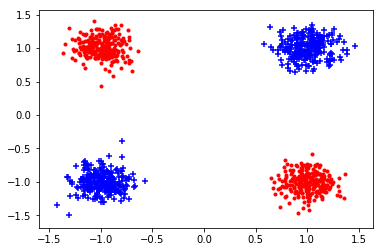

In [67]:
datax, datay = gen_arti(centerx=1,centery=1,sigma=0.02,nbex=1000,data_type=1,epsilon=0.02)
plot_data(datax, datay)

## Construction du modèle

On commence par un premier modèle à une couche cachée avec une tangente hyperbolique.

In [88]:
deltaTan1 = tan1.backward(predLin1, deltaLin2)
print(predLin1)
print(deltaLin2)
print()

#linear1.backward(x, deltaTan1)

[[ 0.22008729  0.252277   -0.81802077  0.33589132  0.20944945]]
[[-0.58899263]
 [ 0.67505191]
 [-0.94608998]
 [-0.33558141]
 [-0.60276935]]
[[-0.56135939 -0.55304194 -0.32143442 -0.52723717 -0.56389138]
 [ 0.64338111  0.63384837  0.36840006  0.60427319  0.64628305]
 [-0.90170313 -0.88834293 -0.51631526 -0.84689311 -0.90577022]
 [-0.31983724 -0.31509833 -0.18313882 -0.30039593 -0.32127985]
 [-0.57448976 -0.56597776 -0.32895287 -0.53956941 -0.57708098]]


In [81]:
linear1 = LinearModule(2, 5)
linear2 = LinearModule(5, 1)
tan1 = Tanh()
tan2 = Tanh()
net = Net([linear1, tan1, linear2, tan2])
mse = MSE()

for k in range(100):
    net.zero_gradient()
    for j in range(200):
        #Shuffle
        np.random.shuffle(indices)
        i = indices[0]
        x = datax[i].reshape((1, -1))
        y = datay[i]
        #Predictions, phase forward
        predLin1 = linear1.forward(x)
        predTan1 = tan1.forward(predLin1)
        predLin2 = linear2.forward(predTan1)
        predTan2 = tan2.forward(predLin2)
        
        #Calcul du cout 
        loss = mse.forward(predTan2, y)
        #Calcul des gradients
        grad_loss = mse.backward(predTan2, y)
        deltaTan2 = tan2.backward(predLin2, grad_loss)
        deltaLin2 = linear2.backward(predTan1, deltaTan2)
        deltaTan1 = tan1.backward(predLin1, deltaLin2)
        linear1.backward(x, deltaTan1)
    linear1.update_params()
    fullpred = net.forward(datax)
    loss_histo.append(mse.forward(net.forward(datax), datay))
    acc_histo.append((np.sign(fullpred) == datay.reshape(fullpred.shape)).mean())

plt.plot(loss_histo)
plt.xlabel("Epoch d'apprentissage")
plt.ylabel("Loss")
plt.title("Valeur du loss en fonction de l'epoch d'apprentissage")

plt.figure()
plt.plot(acc_histo)
plt.xlabel("Epoch d'apprentissage")
plt.ylabel("Accuracy")
plt.title("Valeur de l'accuracy en fonction de l'epoch d'apprentissage")

plt.figure()
make_grid(datax)
plot_frontiere(datax,net.predict,step=1000)
plot_data(datax,datay)


ValueError: shapes (5,5) and (1,2) not aligned: 5 (dim 1) != 1 (dim 0)

0.68503678843075322